Active Learning and Stacking

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, confusion_matrix
from sklearn.utils import shuffle
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import roc_curve, auc

class MetaLearner:
    def __init__(self):
        estimators = [
            ('gbc', GradientBoostingClassifier(n_estimators=100, random_state=42)),
            ('svc', SVC(kernel='rbf', probability=True, random_state=42))
        ]
        self.meta_learner = StackingClassifier(
            estimators=estimators, final_estimator=SVC(kernel='linear', probability=True, random_state=42)
        )

    def fit(self, X, y):
        self.meta_learner.fit(X, y)
        return self

    def predict(self, X):
        return self.meta_learner.predict(X)

df = pd.read_csv('/content/StressLevelDataset.csv')

X = df.drop('stress_level', axis=1)
y = df['stress_level']

X = pd.get_dummies(X)

n_bins = 3
binner = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform', subsample=None)
y_binned = binner.fit_transform(y.values.reshape(-1, 1)).ravel()

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y_binned)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

n_top_features = 10
top_features = X.columns[indices[:n_top_features]]
X_top = X[top_features]

model = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X, y_binned)
X_selected = X[X.columns[rfe.support_]]
# # 5. Feature Importances from RFE (RandomForest)
# plt.figure(figsize=(10, 6))
# sns.barplot(x=rfe.estimator_.feature_importances_, y=X.columns[rfe.support_], palette="plasma")
# plt.title('Feature Importances from RFE (RandomForest)')
# plt.xlabel('Importance Score')
# plt.ylabel('Selected Features by RFE')
# plt.show()

# Choose either X_top or X_selected for further steps
X = X_selected  # or X_top based on preference

initial_size = 0.1
X_train, X_unlabeled, y_train, y_unlabeled = train_test_split(X, y_binned, train_size=initial_size, random_state=42)
X_train, y_train = shuffle(X_train, y_train)

X_train = X_train.values
X_unlabeled = X_unlabeled.values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_unlabeled_scaled = scaler.transform(X_unlabeled)

n_queries = 10
query_size = 0.1
train_sizes = []

for _ in range(n_queries):
    train_sizes.append(len(X_train))

    base_learner = GradientBoostingClassifier(n_estimators=100, random_state=42)
    base_learner.fit(X_train_scaled, y_train)

    meta_features_train = base_learner.predict_proba(X_train_scaled)
    meta_features_unlabeled = base_learner.predict_proba(X_unlabeled_scaled)

    meta_learner = MetaLearner()
    meta_learner.fit(meta_features_train, y_train)

    probas = meta_learner.meta_learner.predict_proba(meta_features_unlabeled)[:, 1]
    uncertainty = np.abs(probas - 0.5)
    query_indices = np.argsort(uncertainty)[:int(query_size * len(X_unlabeled))]

    X_train = np.vstack([X_train, X_unlabeled[query_indices]])
    y_train = np.hstack([y_train, y_unlabeled[query_indices]])

    X_unlabeled = np.delete(X_unlabeled, query_indices, axis=0)
    y_unlabeled = np.delete(y_unlabeled, query_indices)

    X_train_scaled = scaler.fit_transform(X_train)
    X_unlabeled_scaled = scaler.transform(X_unlabeled)

base_learner = GradientBoostingClassifier(n_estimators=100, random_state=42)
base_learner.fit(X_train_scaled, y_train)
meta_features_train = base_learner.predict_proba(X_train_scaled)
meta_features_test = base_learner.predict_proba(scaler.transform(X))

meta_learner = MetaLearner()
meta_learner.fit(meta_features_train, y_train)

y_pred_binned = meta_learner.predict(meta_features_test)

# Evaluation
accuracy = accuracy_score(y_binned, y_pred_binned)
print(f'Accuracy: {accuracy:.4f}')
report = classification_report(y_binned, y_pred_binned)
print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Accuracy: 0.9927
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       373
         1.0       1.00      0.99      1.00       358
         2.0       0.99      0.99      0.99       369

    accuracy                           0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100



In [ ]:
# Access the support vectors from the SVC models in the meta_learner
for name, estimator in meta_learner.meta_learner.named_estimators_.items():
    if isinstance(estimator, SVC):
        print(f"\nSupport Vectors for {name}:")
        print(estimator.support_vectors_)



Support Vectors for svc:
[[0.33745638 0.31411555 0.34842807]
 [0.53350279 0.32814991 0.1383473 ]
 [0.52455938 0.40154417 0.07389645]
 [0.5977023  0.25904581 0.1432519 ]
 [0.66334559 0.06654363 0.27011078]
 [0.40492851 0.09431921 0.50075227]
 [0.43617874 0.33860066 0.2252206 ]
 [0.3409982  0.35310437 0.30589743]
 [0.35944405 0.56304241 0.07751354]
 [0.0897297  0.60148349 0.30878681]
 [0.27748212 0.5203078  0.20221008]
 [0.24798296 0.49833733 0.25367971]
 [0.03474935 0.59011007 0.37514058]
 [0.20199634 0.54712631 0.25087735]
 [0.18336074 0.47177935 0.34485991]
 [0.35280898 0.56007451 0.08711652]
 [0.34771839 0.58905923 0.06322238]
 [0.209262   0.25812533 0.53261268]
 [0.23188882 0.21634668 0.5517645 ]
 [0.09902366 0.31526229 0.58571405]
 [0.14808011 0.28111242 0.57080747]
 [0.2267318  0.24913614 0.52413207]
 [0.26482    0.09659003 0.63858997]
 [0.28832725 0.1192272  0.59244555]]


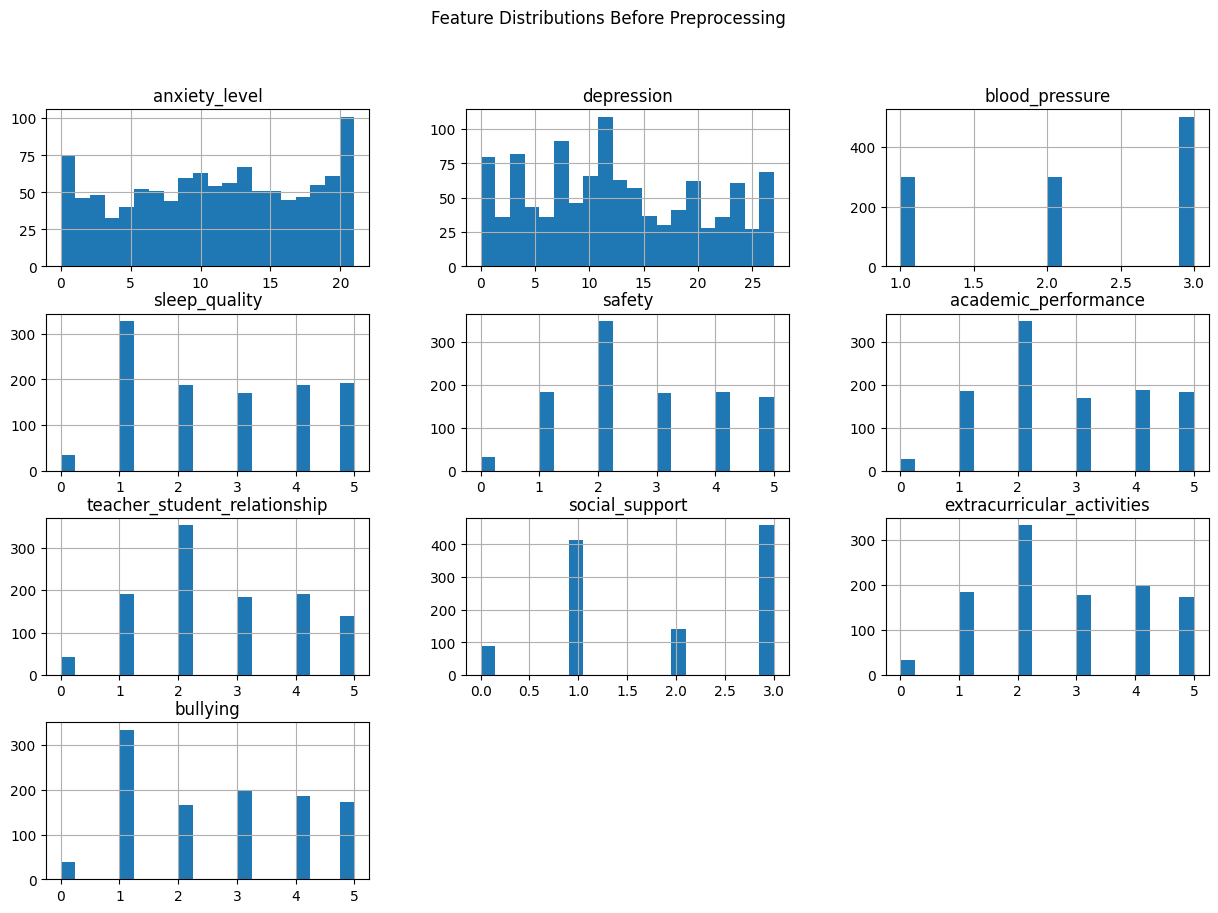

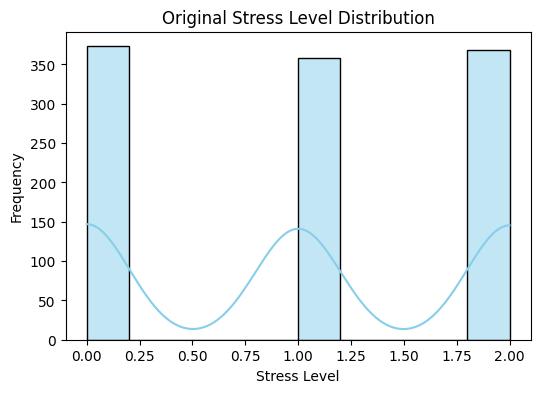

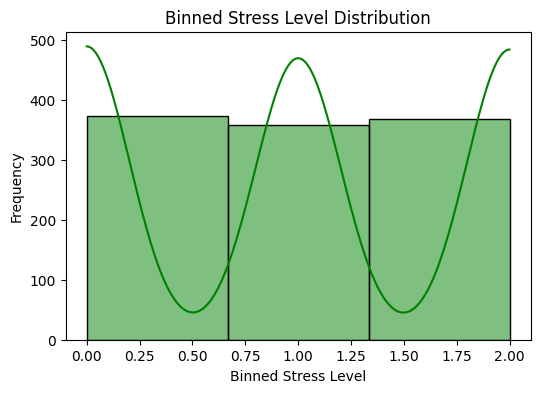

<ipython-input-12-b7ae6f4e9c90>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices[:n_top_features]], y=top_features, palette="viridis")


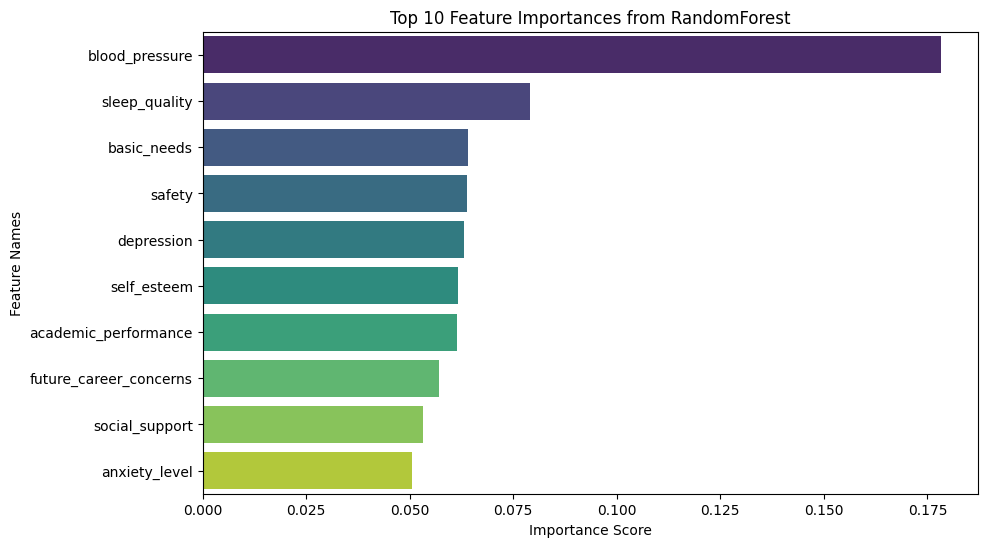

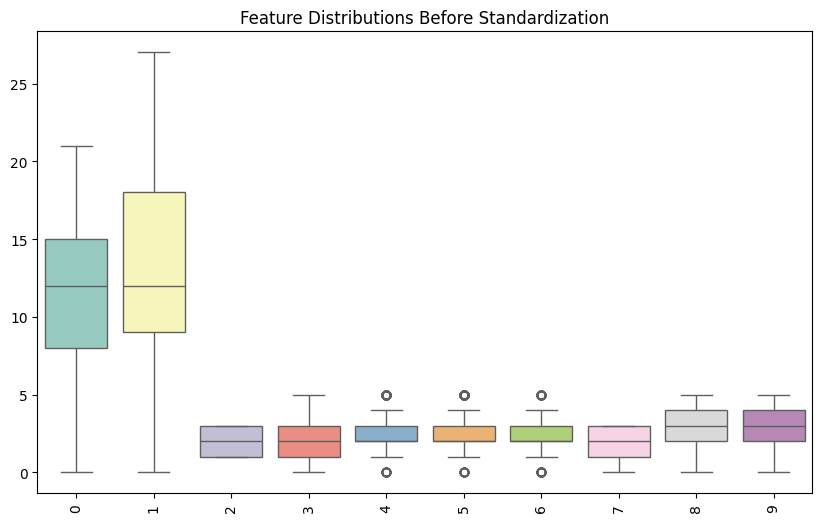

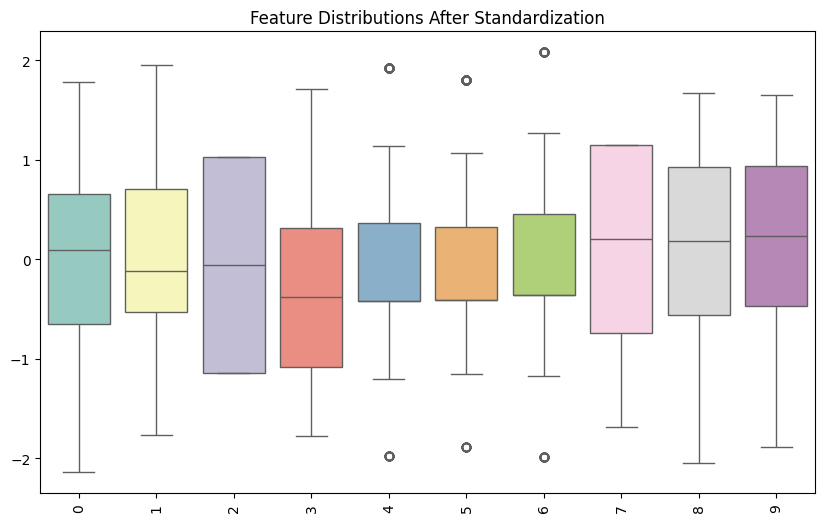

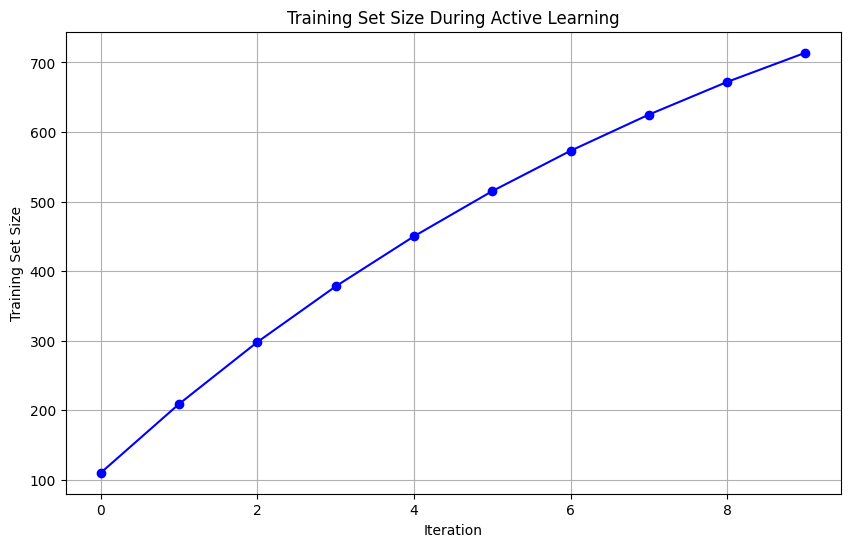

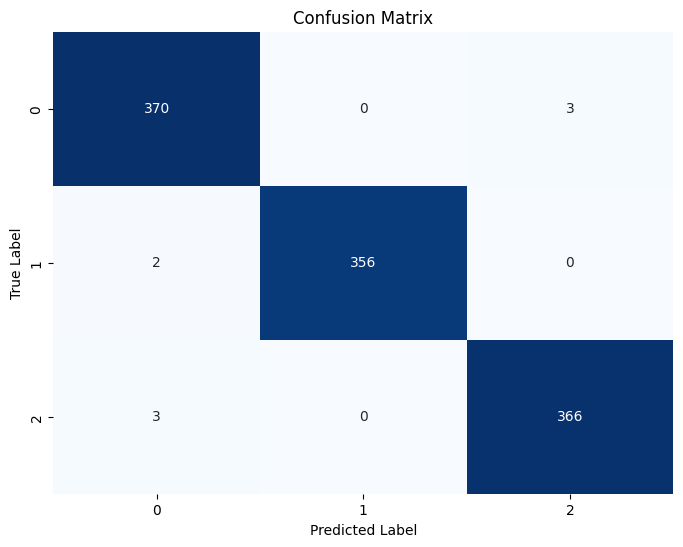

In [ ]:
# 1. Feature Distributions Before Preprocessing
X.hist(bins=20, figsize=(15, 10))
plt.suptitle("Feature Distributions Before Preprocessing")
plt.show()

# 2. Original Stress Level Distribution
plt.figure(figsize=(6, 4))
sns.histplot(y, bins=10, kde=True, color='skyblue')
plt.title('Original Stress Level Distribution')
plt.xlabel('Stress Level')
plt.ylabel('Frequency')
plt.show()

# 3. Binned Stress Level Distribution
plt.figure(figsize=(6, 4))
sns.histplot(y_binned, bins=n_bins, kde=True, color='green')
plt.title('Binned Stress Level Distribution')
plt.xlabel('Binned Stress Level')
plt.ylabel('Frequency')
plt.show()

# 4. Top 10 Feature Importances from RandomForest
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices[:n_top_features]], y=top_features, palette="viridis")
plt.title('Top 10 Feature Importances from RandomForest')
plt.xlabel('Importance Score')
plt.ylabel('Feature Names')
plt.show()

# # 5. Feature Importances from RFE (RandomForest)
# plt.figure(figsize=(10, 6))
# sns.barplot(x=rfe.estimator_.feature_importances_, y=X.columns[rfe.support_], palette="plasma")
# plt.title('Feature Importances from RFE (RandomForest)')
# plt.xlabel('Importance Score')
# plt.ylabel('Selected Features by RFE')
# plt.show()

# 6. Feature Distributions Before Standardization
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train, palette="Set3")
plt.title('Feature Distributions Before Standardization')
plt.xticks(rotation=90)
plt.show()

# 7. Feature Distributions After Standardization
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train_scaled, palette="Set3")
plt.title('Feature Distributions After Standardization')
plt.xticks(rotation=90)
plt.show()

# 8. Training Set Size Growth During Active Learning
plt.figure(figsize=(10, 6))
plt.plot(range(n_queries), train_sizes, marker='o', linestyle='-', color='blue')
plt.title('Training Set Size During Active Learning')
plt.xlabel('Iteration')
plt.ylabel('Training Set Size')
plt.grid(True)
plt.show()
# 9. Confusion Matrix
conf_matrix = confusion_matrix(y_binned, y_pred_binned)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# # 10. ROC Curve
# y_proba = meta_learner.meta_learner.predict_proba(meta_features_test)
# fpr, tpr, _ = roc_curve(y_binned, y_proba[:, 1], pos_label=1)
# roc_auc = auc(fpr, tpr)
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()

Active Learning

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle

df = pd.read_csv('/content/StressLevelDataset.csv')

X = df.drop('stress_level', axis=1)
y = df['stress_level']

X = pd.get_dummies(X)

n_bins = 3
binner = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
y_binned = binner.fit_transform(y.values.reshape(-1, 1)).ravel()

initial_size = 0.1  # Start with 10% of the data as labeled
X_train, X_unlabeled, y_train, y_unlabeled = train_test_split(X, y_binned, train_size=initial_size, random_state=42)
X_train, y_train = shuffle(X_train, y_train)

X_train = X_train.values
X_unlabeled = X_unlabeled.values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_unlabeled_scaled = scaler.transform(X_unlabeled)

n_queries = 10
query_size = 0.1  # Percentage of samples to query in each iteration

for _ in range(n_queries):
    model = GradientBoostingClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    probas = model.predict_proba(X_unlabeled_scaled)

    uncertainty = np.abs(probas[:, 1] - 0.5)
    query_indices = np.argsort(uncertainty)[:int(query_size * len(X_unlabeled))]

    X_train = np.vstack([X_train, X_unlabeled[query_indices]])
    y_train = np.hstack([y_train, y_unlabeled[query_indices]])

    X_unlabeled = np.delete(X_unlabeled, query_indices, axis=0)
    y_unlabeled = np.delete(y_unlabeled, query_indices)

    X_train_scaled = scaler.fit_transform(X_train)
    X_unlabeled_scaled = scaler.transform(X_unlabeled)

final_model = SVC(kernel='linear', probability=True, random_state=42)
final_model.fit(X_train_scaled, y_train)

y_pred_binned = final_model.predict(scaler.transform(X.values))

accuracy = accuracy_score(y_binned, y_pred_binned)
print(f'Final Accuracy with SVM: {accuracy:.4f}')
report = classification_report(y_binned, y_pred_binned)
print(report)
cm = confusion_matrix(y_binned, y_pred_binned)
print("Confusion Matrix:\n", cm)


Final Accuracy with SVM: 0.9109
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91       373
         1.0       0.94      0.91      0.93       358
         2.0       0.88      0.92      0.90       369

    accuracy                           0.91      1100
   macro avg       0.91      0.91      0.91      1100
weighted avg       0.91      0.91      0.91      1100

Confusion Matrix:
 [[338   8  27]
 [ 13 325  20]
 [ 19  11 339]]


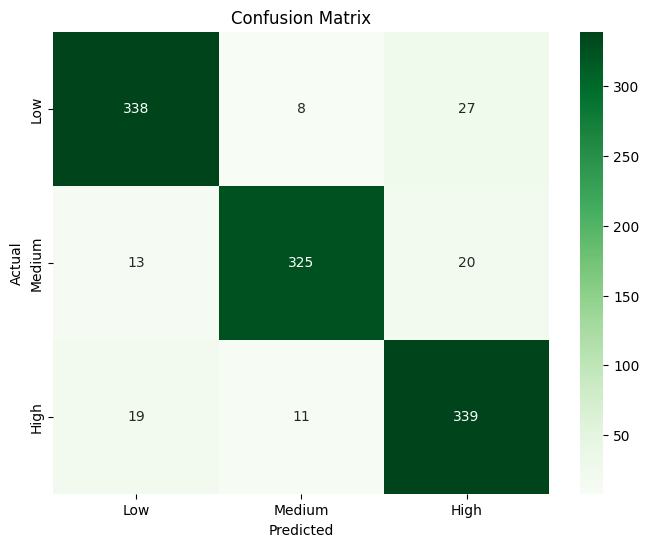

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot the confusion matrix with a different color map
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming 'y_binned' are the true labels and 'y_pred_binned' are the predicted labels from your active learning code
cm = confusion_matrix(y_binned, y_pred_binned)

# Define the labels (e.g., 'Low', 'Medium', 'High' for stress levels)
labels = ['Low', 'Medium', 'High']

# Call the function to plot the confusion matrix
plot_confusion_matrix(cm, labels)


Stacking

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

df = pd.read_csv('/content/StressLevelDataset.csv')

X = df.drop('stress_level', axis=1)
y = df['stress_level']

X = pd.get_dummies(X)

n_bins = 3
binner = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
y_binned = binner.fit_transform(y.values.reshape(-1, 1)).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y_binned, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

base_learners = [
    ('gbc', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
]

meta_learner = SVC(kernel='linear', probability=True, random_state=42)

stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

stacking_model.fit(X_train_scaled, y_train)

y_pred_binned = stacking_model.predict(X_test_scaled)

# Evaluation
accuracy = accuracy_score(y_test, y_pred_binned)
print(f'Accuracy with Dual-Stack Model: {accuracy:.4f}')
report = classification_report(y_test, y_pred_binned)
print(report)
cm = confusion_matrix(y_test, y_pred_binned)
print("Confusion Matrix:\n", cm)


Accuracy with Dual-Stack Model: 0.9061
              precision    recall  f1-score   support

         0.0       0.79      0.99      0.88       113
         1.0       1.00      0.86      0.92       107
         2.0       0.98      0.86      0.92       110

    accuracy                           0.91       330
   macro avg       0.92      0.90      0.91       330
weighted avg       0.92      0.91      0.91       330

Confusion Matrix:
 [[112   0   1]
 [ 14  92   1]
 [ 15   0  95]]


In [ ]:
print(np.bincount(y_binned.astype(int)))

[373 358 369]


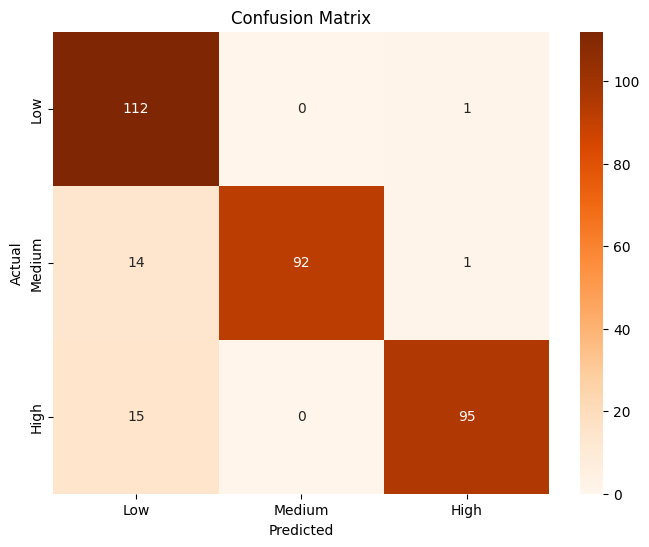

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot the confusion matrix with a different color map
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Labels for the stress levels
labels = ['Low', 'Medium', 'High']

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_binned)

# Plot the confusion matrix
plot_confusion_matrix(cm, labels)

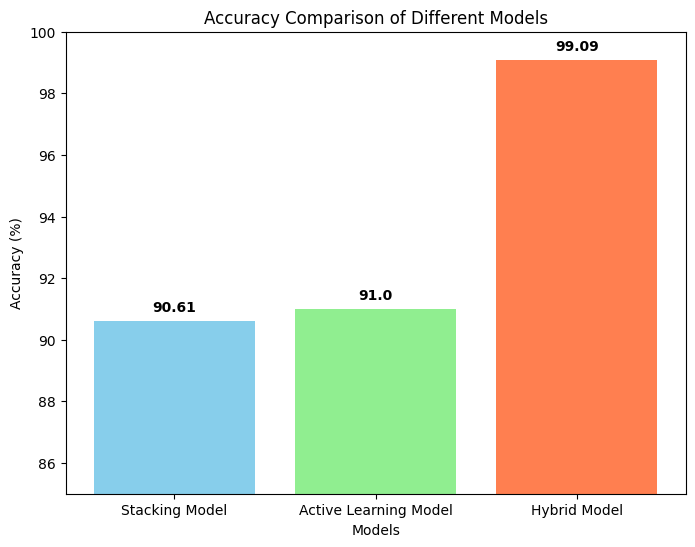

In [ ]:
import matplotlib.pyplot as plt

# Model names
models = ['Stacking Model','Active Learning Model', 'Hybrid Model']

# Accuracy values
accuracies = [90.61, 91.00, 99.09]

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'coral'])

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison of Different Models')

# Display accuracy values on top of the bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.3, str(v), ha='center', fontweight='bold')

# Show the plot
plt.ylim([85, 100])  # Adjust y-axis for better visibility
plt.show()
